## Imports & Settings

In [1]:
import os
os.chdir('..')
# os.getcwd( )

In [2]:
from utils import *

import re
import nltk
import string
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import datasets
from datasets import load_dataset, load_metric, Dataset

## Load Dataset

"This is the XED dataset. The dataset consists of emotion annotated movie subtitles from OPUS. We use Plutchik's 8 core emotions to annotate. The data is multilabel. The original annotations have been sourced for mainly English and Finnish. For the English data we used Stanford NER (named entity recognition) (Finkel et al., 2005) to replace names and locations with the tags: [PERSON] and [LOCATION] respectively. For the Finnish data, we replaced names and locations using the Turku NER corpus (Luoma et al., 2020)."

Where the number indicates the emotion in ascending alphabetical order: <br /><br />
<b>anger</b>: 1 <br />
<b>anticipation</b>: 2 <br />
<b>disgust</b>: 3<br /> 
<b>fear</b>: 4<br />
<b>joy</b>: 5<br /> 
<b>sadness</b>: 6<br /> 
<b>surprise</b>: 7<br /> 
<b>trust</b>: 8<br /> 
with neutral</b>: 0 where applicable.

In [3]:
dataset = load_dataset("xed_en_fi", "en_annotated")
dataset

Found cached dataset xed_en_fi (/Users/jarradjinx/.cache/huggingface/datasets/xed_en_fi/en_annotated/1.1.0/da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels'],
        num_rows: 17528
    })
})

In [4]:
# save dataset locally as a backup
dataset.save_to_disk("data/inter_XED/source_xed_en_fi_en_annotated.hf")

Saving the dataset (0/1 shards):   0%|          | 0/17528 [00:00<?, ? examples/s]

In [5]:
xed_df = dataset['train'].to_pandas() 
xed_df = xed_df.rename(columns={'sentence': 'text'})
xed_df = xed_df.rename(columns={'labels': 'label'})
xed_df.head()

,text,label
0,", ...",[1]
1,!,"[1, 4, 7]"
2,... And I don't think we need to discuss the T...,"[8, 1]"
3,* So get up out of your bed,[1]
4,A confession that you hired [PERSON] ... and a...,"[1, 6]"


In [6]:
xed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17528 entries, 0 to 17527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17528 non-null  object
 1   label   17528 non-null  object
dtypes: object(2)
memory usage: 274.0+ KB


## Clean Labels
This dataset contains multiple labels for some observations. To simplify things, we remove all multi-label observations. This leaves us with 13,655 single-label entires with which to experiment.

In [7]:
# find items with single label
xed_df = xed_df[xed_df['label'].map(len) == 1 ]
xed_df.head(25)

,text,label
0,", ...",[1]
3,* So get up out of your bed,[1]
5,A dead man has one half - hour to raise his ro...,[1]
6,A guy that's talking about he's gonna solve al...,[1]
7,A guy who was a pain in the neck even before I...,[1]
9,A lady wouldn't work for this outfit .,[1]
10,A little dicey doing a background on an FBI ag...,[1]
11,A little restraint ?,[1]
12,A little rush ?,[1]
13,"A lost decade , but it was worth it to make yo...",[1]


In [8]:
xed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13655 entries, 0 to 17527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13655 non-null  object
 1   label   13655 non-null  object
dtypes: object(2)
memory usage: 320.0+ KB


### Cast Labels as Integers

In [9]:
# pull first (only) item out of each array
xed_df['label'] = xed_df['label'].apply(lambda x: x[0])

xed_df.head()

,text,label
0,", ...",1
3,* So get up out of your bed,1
5,A dead man has one half - hour to raise his ro...,1
6,A guy that's talking about he's gonna solve al...,1
7,A guy who was a pain in the neck even before I...,1


## View Label Distribution

[Text(0, 0, '2391'),
 Text(0, 0, '2028'),
 Text(0, 0, '1413'),
 Text(0, 0, '1529'),
 Text(0, 0, '1721'),
 Text(0, 0, '1527'),
 Text(0, 0, '1429'),
 Text(0, 0, '1617')]

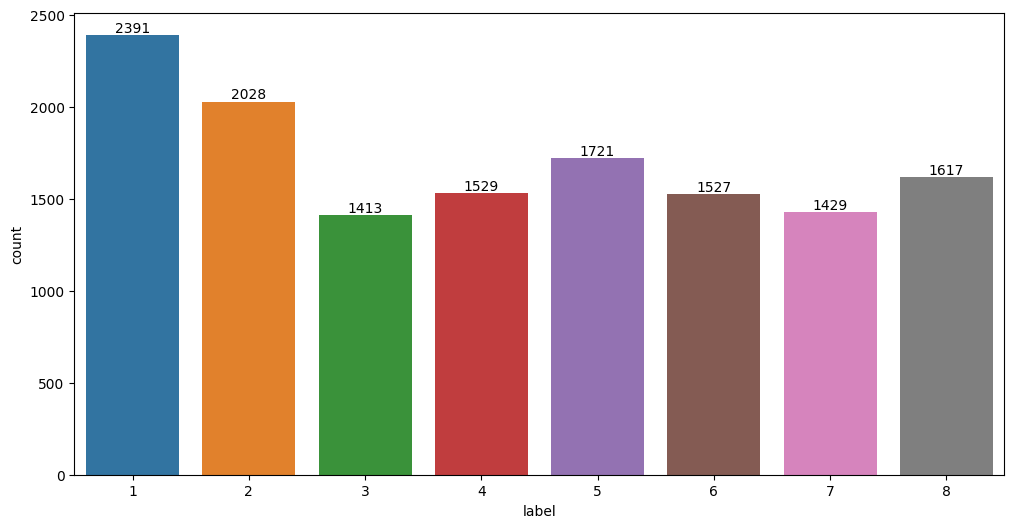

In [10]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=xed_df)
ax.bar_label(ax.containers[0])

## View Word Counts & Word Count Distribution 

In [11]:
xed_df['num_word_text'] = xed_df['text'].apply(lambda x:len(str(x).split()))
xed_df.head()

,text,label,num_word_text
0,", ...",1,2
3,* So get up out of your bed,1,8
5,A dead man has one half - hour to raise his ro...,1,20
6,A guy that's talking about he's gonna solve al...,1,12
7,A guy who was a pain in the neck even before I...,1,16


In [12]:
xed_df.describe()

,label,num_word_text
count,13655.000000,13655.000000
mean,4.211498,8.947345
std,2.374662,4.786118
min,1.000000,2.000000
25%,2.000000,6.000000
50%,4.000000,8.000000
75%,6.000000,11.000000
max,8.000000,46.000000


<AxesSubplot: xlabel='num_word_text', ylabel='Count'>

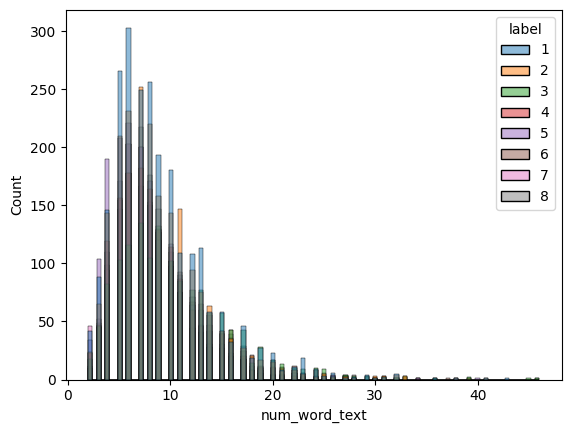

In [13]:
sns.histplot(x="num_word_text", data=xed_df,  hue="label", palette="tab10")

In [14]:
pd.options.display.max_colwidth = 100
xed_df['text']

0                                                                                      , ...
3                                                                * So get up out of your bed
5        A dead man has one half - hour to raise his roll outside and get back in the game .
6                            A guy that's talking about he's gonna solve all your problems .
7                         A guy who was a pain in the neck even before I carried his stuff .
                                                ...                                         
17523                                                       Your opinion might be valuable .
17524                                                                          Your orders .
17525                                                  Your ship's been in lots of battles .
17526                                                             Your wine , your Majesty .
17527                                                                 

### Longest Entries

In [15]:
pd.options.display.max_colwidth = 200
xed_df.loc[xed_df['num_word_text'] == 46]


,text,label,num_word_text
3681,"Director of Central Intelligence would give to Carters the president - elect all of the information he had on the potential existence of extraterrestrial life , and the issue of whether or not any...",8,46
10192,I don't resent your not paying me for the past two months ... but the thought that I should split my bank account with you ... that you should take half of my life's savings ... that is really too...,3,46


### Shortest Entries

In [16]:
xed_df.loc[xed_df['num_word_text'] == 2]

,text,label,num_word_text
0,", ...",1,2
71,Altitude !,1,2
230,Bastard !,1,2
231,Bastard .,1,2
232,Bastards .,1,2
...,...,...,...
16923,Shalakazam .,8,2
16945,Sir !,8,2
17208,We .,8,2
17310,Wow .,8,2


#### View Tokenized Length
Below, we find that the tokenized XED sequences are quite short.

In [17]:
train_token_id = []

# encode training text
for sample in xed_df.text.values:
  encoding_dict = preprocessing_dyna(sample, params.tokenizer)
  # parse encoding dict to lists
  train_token_id.append(encoding_dict['input_ids']) 

In [18]:
train_token_id[:2]

[[0, 6, 1666, 2], [0, 3226, 407, 120, 62, 66, 9, 110, 3267, 2]]

In [19]:
lengths = []
for i in train_token_id:
    lengths.append(len(i))

print(len(lengths))
print(lengths[:10])
print(f'Max Tokenized Sequence Length: {max(lengths)}')

13655
[4, 10, 22, 16, 18, 11, 14, 6, 6, 20]
Max Tokenized Sequence Length: 62


## Adjust & Export Datasets for Train/Validate/Test

In [20]:
# shuffle dataframe and reset index
xed_df = xed_df.sample(frac=1, random_state=1).reset_index(drop=True)

xed_df.head()

,text,label,num_word_text
0,Who were you expecting ?,7,5
1,"One more to go , chicken .",1,7
2,Where'd you get that ?,2,5
3,Sometimes they have an accident .,6,6
4,I haven't been up this early in years .,7,9


In [21]:
xed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           13655 non-null  object
 1   label          13655 non-null  int64 
 2   num_word_text  13655 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 320.2+ KB


### Test Split

In [22]:
# get 1,655 sample
xed_test = xed_df.sample(1655, random_state=1)
xed_test

,text,label,num_word_text
12277,I'm just curious .,2,4
4721,"If you hadn't promised so faithfully , I wouldn't have planned the whole thing .",1,15
663,But they turned the lights down this time and didn't say this is a drill .,4,16
11087,This is junk .,3,4
11642,"Listen , [PERSON] , why don't you come down with us ?",2,12
...,...,...,...
7617,"Yeah , then why are you trying to hurt me ?",4,11
6665,What if they catch the Captain before he gets help ?,4,11
9193,I want to sit in front .,2,7
9218,"You know , I still expect him to come home for dinner .",6,13


In [23]:
# remove test set samples from dataset
xed_df = xed_df.drop(xed_test.index)
xed_df


,text,label,num_word_text
0,Who were you expecting ?,7,5
1,"One more to go , chicken .",1,7
2,Where'd you get that ?,2,5
3,Sometimes they have an accident .,6,6
5,"I'm sorry , are we here to have a sarcastic back and forth , or would you like to exchange useful information ?",1,23
...,...,...,...
13650,Act your age !,3,4
13651,What a jerk .,1,4
13652,What else do you have to tell ?,7,8
13653,"Come on , [PERSON] . We got ta move !",1,10


### Validation Split

In [24]:
# get 2,400 samples
xed_validation = xed_df.sample(2400, random_state=1)
xed_validation

,text,label,num_word_text
8138,It's hard to be strict with a man who loses money so pleasantly .,3,14
11820,You are all welcome to drink the bar dry .,5,10
2154,Do you think it's an epidemic like the flu ?,4,10
3862,We're losing the wind !,4,5
13306,What's killing all the children ?,4,6
...,...,...,...
12767,Look at me !,1,4
2431,I'm ready to testify . He'll go to jail .,8,10
5945,Your blood will thicken .,1,5
1146,Frank . The Benzedrine's got my teeth wiggling .,3,9


In [25]:
# remove validation set samples from dataset
xed_df = xed_df.drop(xed_validation.index)
xed_df


,text,label,num_word_text
0,Who were you expecting ?,7,5
1,"One more to go , chicken .",1,7
2,Where'd you get that ?,2,5
3,Sometimes they have an accident .,6,6
7,( isaac crying ) - it's cranky time .,4,9
...,...,...,...
13650,Act your age !,3,4
13651,What a jerk .,1,4
13652,What else do you have to tell ?,7,8
13653,"Come on , [PERSON] . We got ta move !",1,10


### Train Split

[Text(0, 0, '1648'),
 Text(0, 0, '1426'),
 Text(0, 0, '1023'),
 Text(0, 0, '1087'),
 Text(0, 0, '1186'),
 Text(0, 0, '1088'),
 Text(0, 0, '1012'),
 Text(0, 0, '1130')]

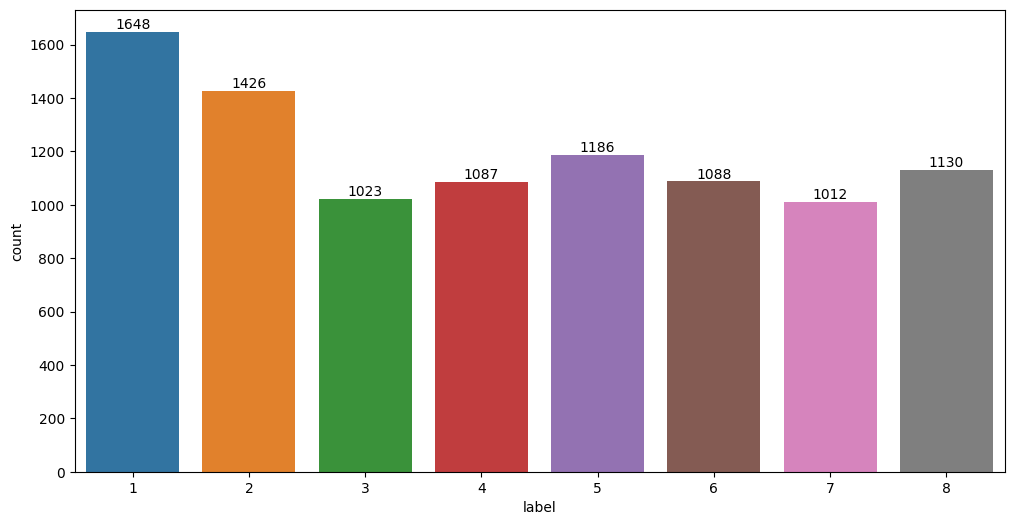

In [26]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=xed_df)
ax.bar_label(ax.containers[0])

In [27]:
# get samples for each class equal to the number of available samples for the smallest class
xed_train = xed_df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), min(np.unique(xed_df['label'], return_counts=True)[1])), random_state=1).sample(frac=1, random_state=1))
xed_train

,text,label,num_word_text
12159,"No one picked on you , [PERSON] .",1,8
1530,Go and say sorry to him . ',1,8
8332,"For your information , I was at [LOCATION] .",1,9
10305,"What , are you guys blind or something ?",1,9
6399,That's the trouble with you .,1,6
...,...,...,...
9797,"He was a [LOCATION] bus driver , and when I was a boy , he used to take me over the river to [LOCATION] , where the rich people lived .",8,31
8409,Your ship's been in lots of battles .,8,8
12665,Say the word .,8,4
210,"Honey , why don't you go out to the kitchen and bring us some of those ... fancy little hors d'oeuvres .",8,22


### Double-Check Distribution
Our training set distribution is perfectly balanced while our validation and test sets are representative of the original dataset's distribution.

Text(0.5, 1.0, 'Train Set Label Distribution')

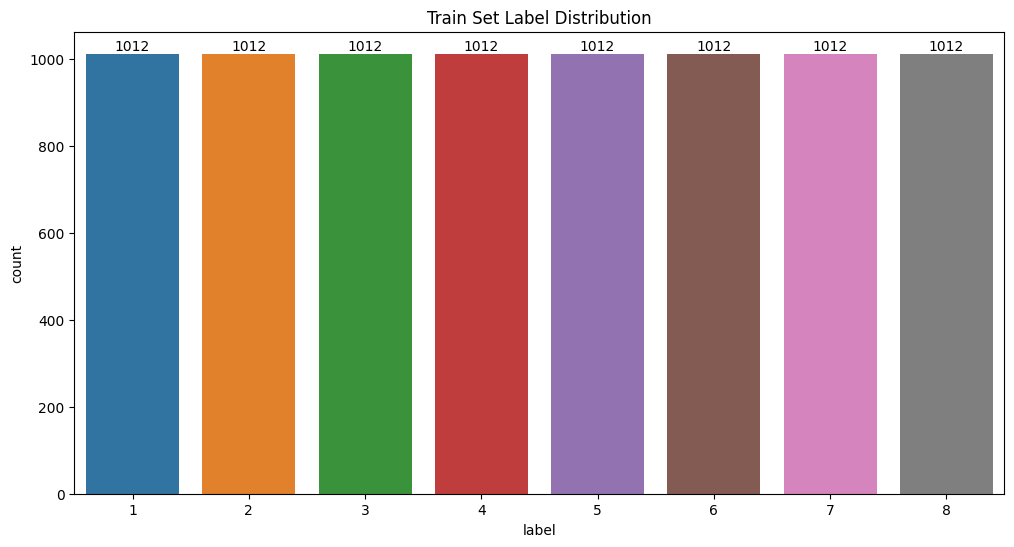

In [28]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=xed_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

2400


Text(0.5, 1.0, 'Validation Set Label Distribution')

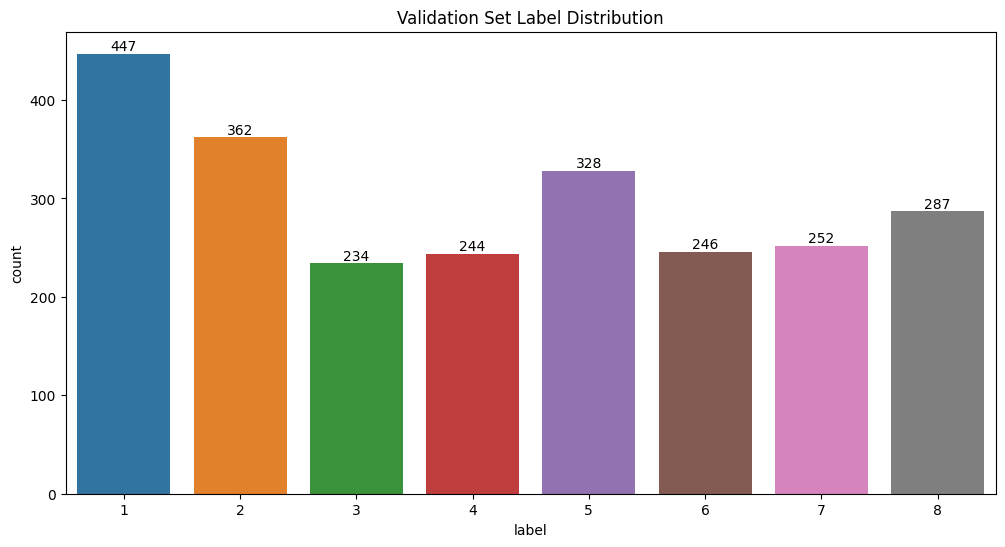

In [29]:
print(len(xed_validation))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=xed_validation)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

1655


Text(0.5, 1.0, 'Test Set Label Distribution')

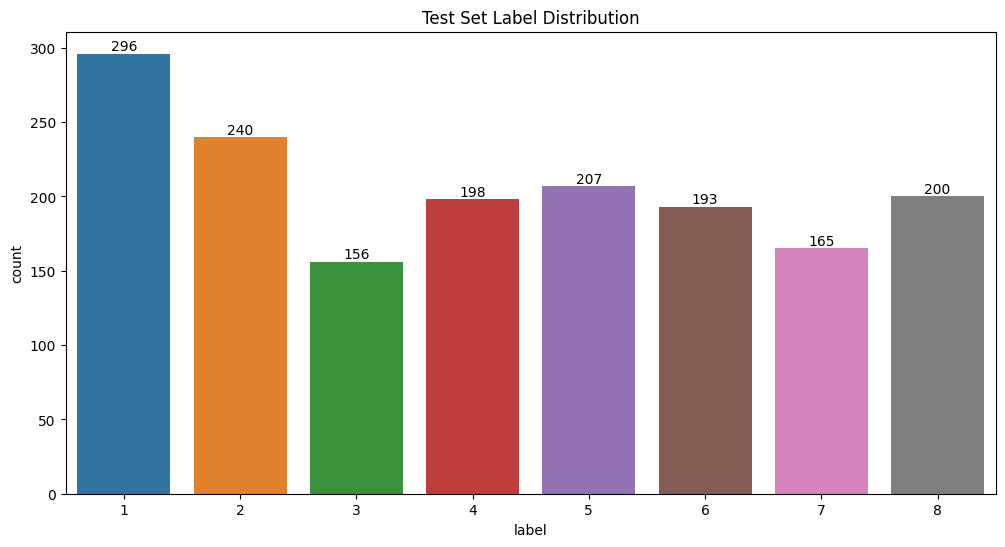

In [30]:
print(len(xed_test))
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=xed_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

## Export Fine-Grain Datasets

In [34]:
# reconstitute the updated datafames into a DatasetDict object
fine_train_dataset = Dataset.from_pandas(xed_train,  preserve_index=False)
fine_validate_dataset = Dataset.from_pandas(xed_validation, preserve_index=False)
fine_test_dataset = Dataset.from_pandas(xed_test, preserve_index=False)
xed_fine_datasets = datasets.DatasetDict({"train":fine_train_dataset, 
                                          "validation":fine_validate_dataset, 
                                          "test":fine_test_dataset})

In [35]:
xed_fine_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 8096
    })
    validation: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 1655
    })
})

In [ ]:
xed_fine_datasets.save_to_disk("data/inter_XED/itesd_xed_fine_balanced.hf")

## Prep Binary Train/Test Data
This dataset is the same as the fine-grain XED dataset above except that we set the labels according to the polarized emotions (positive and negative). We group all the emotion labels with negative insight (sadness, fear, anger, disgust) into a negative sentiment label (0) and group the remaining emotions (joy, surprise, trust, anticipation) into a positive class. <br /><br />
<b>anger</b> (negative): 1->0 <br />
<b>anticipation</b> (positive): 2->1 <br />
<b>disgust</b> (negative): 3->0<br /> 
<b>fear</b> (negative): 4->0<br />
<b>joy</b> (positive): 5->1<br /> 
<b>sadness</b> (negative): 6->0<br /> 
<b>surprise</b> (positive): 7->1<br /> 
<b>trust</b> (positive): 8->1<br /> 

In [36]:
binary_train = xed_train.copy()
binary_validation = xed_validation.copy()
binary_test = xed_test.copy()

print(len(binary_train))
print(len(binary_validation))
print(len(binary_test))

8096
2400
1655


In [37]:
binary_train['label'] = binary_train['label'].map({1: 0, 
                                                   2: 1,
                                                   3: 0, 
                                                   4: 0,
                                                   5: 1, 
                                                   6: 0,
                                                   7: 1, 
                                                   8: 1})
                            
binary_validation['label'] = binary_validation['label'].map({1: 0, 
                                                   2: 1,
                                                   3: 0, 
                                                   4: 0,
                                                   5: 1, 
                                                   6: 0,
                                                   7: 1, 
                                                   8: 1})

binary_test['label'] = binary_test['label'].map({1: 0, 
                                                 2: 1,
                                                 3: 0, 
                                                 4: 0,
                                                 5: 1, 
                                                 6: 0,
                                                 7: 1, 
                                                 8: 1})

In [38]:
binary_train.head()

,text,label,num_word_text
12159,"No one picked on you , [PERSON] .",0,8
1530,Go and say sorry to him . ',0,8
8332,"For your information , I was at [LOCATION] .",0,9
10305,"What , are you guys blind or something ?",0,9
6399,That's the trouble with you .,0,6


### Double-Check Distribution
The distribution of labels is fairly even, so we will not over or undersample.

Text(0.5, 1.0, 'Train Set Label Distribution')

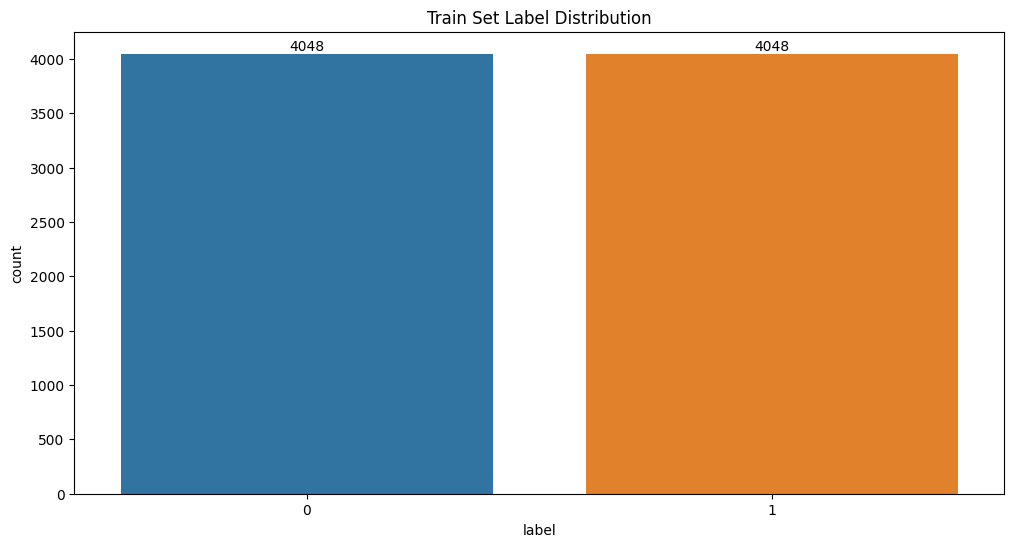

In [39]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=binary_train)
ax.bar_label(ax.containers[0])
plt.title("Train Set Label Distribution")

Text(0.5, 1.0, 'Validation Set Label Distribution')

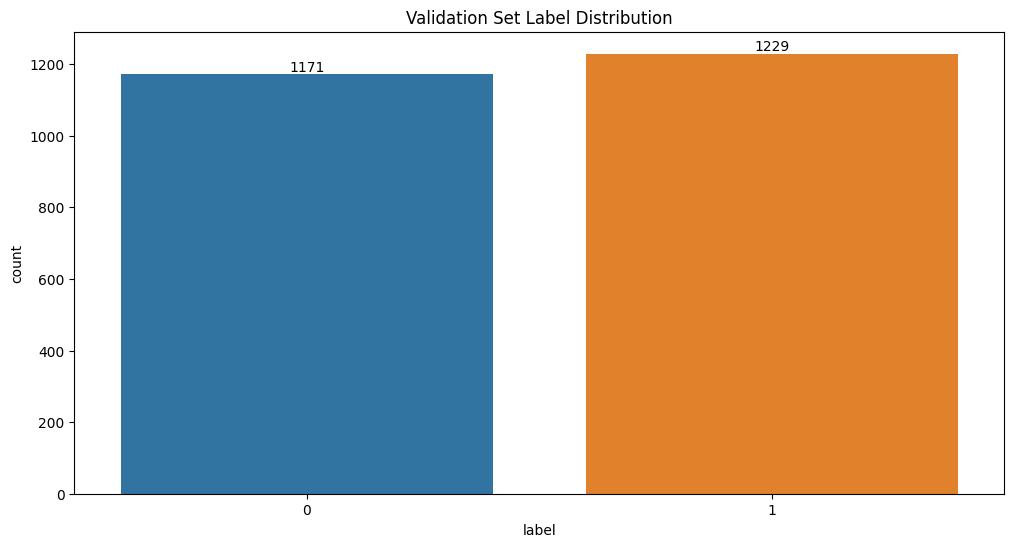

In [40]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=binary_validation)
ax.bar_label(ax.containers[0])
plt.title("Validation Set Label Distribution")

Text(0.5, 1.0, 'Test Set Label Distribution')

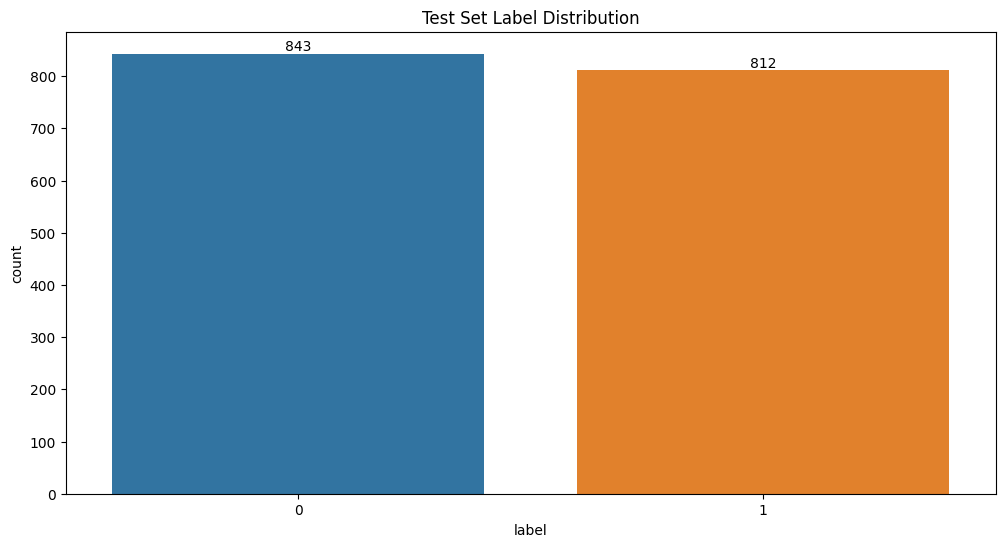

In [41]:
fig = plt.figure(figsize=(12, 6))
ax = sns.countplot(x='label', data=binary_test)
ax.bar_label(ax.containers[0])
plt.title("Test Set Label Distribution")

### Export Binary Datasets

In [42]:
# reconstitute the updated datafames into a DatasetDict object
binary_train_dataset = Dataset.from_pandas(binary_train, preserve_index=False)
binary_validate_dataset = Dataset.from_pandas(binary_validation, preserve_index=False)
binary_test_dataset = Dataset.from_pandas(binary_test, preserve_index=False)
xed_binary_datasets = datasets.DatasetDict({"train":binary_train_dataset, 
                                          "validation":binary_validate_dataset, 
                                          "test":binary_test_dataset})

In [43]:
xed_binary_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 8096
    })
    validation: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 2400
    })
    test: Dataset({
        features: ['text', 'label', 'num_word_text'],
        num_rows: 1655
    })
})

In [ ]:
xed_binary_datasets.save_to_disk("data/inter_XED/itesd_xed_binary_balanced.hf")